# 数据挖掘 互评作业2 -part1

> GitHub Address: [part1](https://github.com/Nonsensersunny/bit-data-mining/blob/master/homework-6/%E6%95%B0%E6%8D%AE%E6%8C%96%E6%8E%98%20%E4%BA%92%E8%AF%84%E4%BD%9C%E4%B8%9A2%20-part1.ipynb)

> 选取的数据集为 [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews)


## 1. 数据预处理

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import csv
import itertools

# 变量声明
data = dict()

country = dict()
designation = dict()
points = dict()
price = dict()
province = dict()
variety = dict()
winery = dict()

# 导入数据集
with open('wine-reviews/winemag-data_first150k.csv', 'r') as f:
    fi = csv.reader(f)
    row = 0
    cnt = 0
    for l in fi:
        if row == 0:
            pass
        else:
            c = l[1]
            d = l[3]
            po = l[4]  
            pr = l[5]  
            p = l[6]
            v = l[9]
            w = l[10]
            if c and d and p and v and w and po and pr:
                if c in country.keys():
                    country[c] += 1
                else:
                    country[c] = 1
                if d in designation.keys():
                    designation[d] += 1
                else:
                    designation[d] = 1
                if p in province.keys():
                    province[p] += 1
                else:
                    province[p] = 1
                if v in variety.keys():
                    variety[v] += 1
                else:
                    variety[v] = 1
                if w in winery.keys():
                    winery[w] += 1
                else:
                    winery[w] = 1
                m = (round(float(po)) - 80) 
                if m in points.keys():
                    points[m] += 1
                else:
                    points[m] = 1
                n = (round(float(pr)) - 4) 
                if round(float(pr)) > 76:
                    n = 5
                if n in price.keys():
                    price[n] += 1
                else:
                    price[n] = 1
                m = 'points_' + str(m)
                n = 'price_' + str(n)
                data[cnt] = [c, d, p, v, w, m, n]
                cnt += 1
        row += 1

## 2. Apriori 算法实现

In [2]:
class Apriori:
    def __init__(self, min_sup=0.2, dataDic={}):
        self.data = dataDic
        self.size = len(dataDic)
        self.min_sup = min_sup
        self.min_sup_val = min_sup * self.size

    def l_1_items(self):
        FreqDic = {}
        L1_item  = dict()
        for event in self.data:
            for item in self.data[event]:
                if item in FreqDic:
                    FreqDic[item] += 1
                else:
                    FreqDic[item] = 1
        L1 = []
        for itemset in FreqDic:
            if FreqDic[itemset] >= self.min_sup_val: 
                L1.append([itemset])  
                L1_item[itemset] = FreqDic[itemset]

        return L1, L1_item
    
    # truncate
    def apriori_gen(self, L_last):
        k = len(L_last[0]) + 1
        Ck = []
        for itemset1 in L_last:
            for itemset2 in L_last:
                flag = 0
                for i in range(k - 2):
                    if itemset1[i] != itemset2[i]:
                        flag = 1
                        break;
                if flag == 1:
                    continue
                if itemset1[k - 2] < itemset2[k - 2]:
                    c = itemset1 + [itemset2[k - 2]]
                else:
                    continue
                if self.has_infrequent_subset(c, L_last, k):
                    continue
                else:
                    Ck.append(c)
        return Ck

    # transcendence
    def has_infrequent_subset(self, c, L_last, k):
        subsets = list(itertools.combinations(c, k - 1))
        for each in subsets:
            each = list(each)
            if each not in L_last:
                return True
        return False

    def generate(self):
        L_last, _ = self.l_1_items()
        L = L_last
        i = 0
        j = 2
        L2_item = dict()

        while L_last != []:
            Ck = self.apriori_gen(L_last)
            FreqDic = {}
            for event in self.data:
                for c in Ck:
                    if set(c) <= set(self.data[event]):
                        if tuple(c) in FreqDic:
                            FreqDic[tuple(c)] += 1
                        else:
                            FreqDic[tuple(c)] = 1
            Lk = []
            num = []
            Lo = []
            for c in FreqDic:
                if FreqDic[c] > self.min_sup_val:
                    Lk.append(list(c))
                    num.append(FreqDic[c])

            L_last = Lk
            L += Lk

            if len(Lk) != 0:
                for i in range(0, len(Lk)):
                    content = ""
                    for j in range(len(Lk[i])):
                        content = content + Lk[i][j] + '+'
                    content = content[:-1]
                    L2_item[content] = num[i]
                j += 1
        return L, L2_item

## 3. 关联规则挖掘
### 3.1 频繁项集

In [3]:
apr = Apriori(dataDic=data)
L1, L1_item = apr.l_1_items()
res, L2_item = apr.generate()
L2 = []

# print all
print('枚举所有频繁项集：')
for i in res:
    print(i)
    
# print L1
print('\n1-项集')
for i in L1_item.keys():
    print(i, ':', L1_item[i])
    
# print L2
print('\n2-项集')
for i in L2_item.keys():
    L2.append(i)
    print(i, ':', L2_item[i])

枚举所有频繁项集：
['US']
['California']
['California', 'US']

1-项集
US : 40155
California : 28683

2-项集
California+US : 28683


### 3.2 支持度和置信度计算

In [4]:
support = [] # 支持度
confidence = [] # 置信度
for item in L2_item:
    num = L2_item[item]
    s = num / len(data)
    support.append(s)
    print(f'{item}的支持度为：{s}')

    # 计算置信度
    condition = item.split('+')[0]
    condition_num = L1_item[condition]
    c = num / condition_num
    confidence.append(c)
    print(f'{item}的置信度为：{c}')
    
print(support, confidence)

California+US的支持度为：0.3021839673827158
California+US的置信度为：1.0
[0.3021839673827158] [1.0]


### 3.3 规则评价
#### 3.3.1 Kulc 方法

In [5]:
kulc_scores = []
for item in L2_item:
    num = L2_item[item]
    its = item.split('+')
    first = L1_item[its[0]]
    second = L1_item[its[1]]
    first_pro = num / first
    second_pro = num / second
    kulc = (first_pro + second_pro) / 2
    kulc_scores.append(kulc)
    print(f'Kulc of {item}: {kulc}')

Kulc of California+US: 0.857153530070975


#### 3.3.2 Lift 方法

In [7]:
lift_scores = []
for item in L2_item:
    num = L2_item[item]
    its = item.split('+')
    first = L1_item[its[0]]
    second = L1_item[its[1]]
    lift = (num / len(data)) / ((first / len(data)) * (second / len(data)))
    lift_scores.append(lift)
    print(f'Lift of {item}: {lift}')

Lift of California+US: 2.363815216037853


## 4. 可视化
### 4.1 支持度与置信度可视化

['California+US']


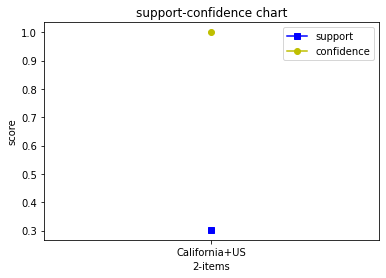

In [8]:
x = L2  
print(x)
k1 = support 
k2 = confidence  
plt.plot(x, k1, 's-', color = 'b', label="support")  
plt.plot(x, k2, 'o-', color = 'y', label="confidence")  
plt.xlabel("2-items") 
plt.ylabel("score") 
plt.legend(loc="best") 
plt.title("support-confidence chart")
plt.show()

### 4.2 规则评价可视化

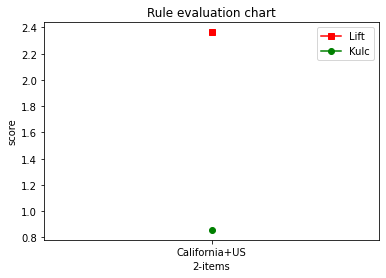

In [9]:

# 规则评价的结果折线图
x = L2  # 点的横坐标
k1 = lift_scores # lift纵坐标
k2 = kulc_scores  # kulc的纵坐标
plt.plot(x, k1, 's-', color = 'r', label="Lift")  #s-:方形
plt.plot(x, k2, 'o-', color = 'g', label="Kulc")  #o-:圆形
plt.xlabel("2-items")  # 横坐标名字
plt.ylabel("score")  # 纵坐标名字
plt.legend(loc="best")  # 图例
plt.title("Rule evaluation chart")
plt.show()